In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
rcParams['figure.figsize'] = 12,5
import warnings
warnings.filterwarnings("ignore")

In [2]:
df1 = pd.read_csv('../Data/DailyTotalFemaleBirths.csv',index_col='Date',parse_dates=True)
df1.index.freq = 'D'
df1 = df1[:120] 

In [3]:
df2 = pd.read_csv('../Data/TradeInventories.csv', index_col=0, parse_dates=True)

In [4]:
df2.index.freq = 'MS'

In [5]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [6]:
adf_test(df1['Births'])

# non-stationary

Augmented Dickey-Fuller Test: 
ADF test statistic     -9.855384e+00
p-value                 4.373545e-17
# lags used             0.000000e+00
# observations          1.190000e+02
critical value (1%)    -3.486535e+00
critical value (5%)    -2.886151e+00
critical value (10%)   -2.579896e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


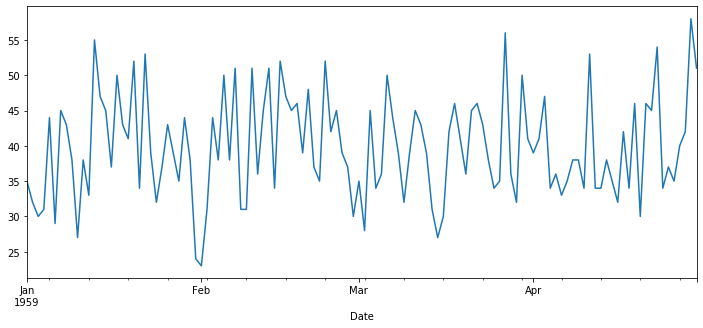

In [7]:
df1['Births'].plot();

In [8]:
from pmdarima import auto_arima

In [9]:
grid = auto_arima(df1['Births'], start_p=0, start_q=0, max_p=6, max_q=6, seasonal=False, trace=True)

Fit ARIMA: order=(0, 0, 0); AIC=823.489, BIC=829.064, Fit time=0.007 seconds
Fit ARIMA: order=(1, 0, 0); AIC=824.647, BIC=833.010, Fit time=0.024 seconds
Fit ARIMA: order=(0, 0, 1); AIC=824.747, BIC=833.110, Fit time=0.041 seconds
Fit ARIMA: order=(1, 0, 1); AIC=826.399, BIC=837.549, Fit time=0.121 seconds
Total fit time: 0.199 seconds


In [10]:
grid.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  120
Model:                     ARMA(0, 0)   Log Likelihood                -409.745
Method:                           css   S.D. of innovations              7.357
Date:                Fri, 03 Jul 2020   AIC                            823.489
Time:                        20:50:18   BIC                            829.064
Sample:                             0   HQIC                           825.753
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         39.7833      0.672     59.240      0.000      38.467      41.100
==============================================================================
"""

In [11]:
# Train test split

In [12]:
train = df1[:90]

In [13]:
test = df1[90:]

In [14]:
start = len(train)
end = len(train)+len(test)-1

In [15]:
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults, ARMA, ARMAResults

In [16]:
model = ARMA(train['Births'], order=(1,0))

In [17]:
fitted_model = model.fit()

In [18]:
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 Births   No. Observations:                   90
Model:                     ARMA(1, 0)   Log Likelihood                -308.054
Method:                       css-mle   S.D. of innovations              7.417
Date:                Fri, 03 Jul 2020   AIC                            622.107
Time:                        20:50:18   BIC                            629.607
Sample:                    01-01-1959   HQIC                           625.132
                         - 03-31-1959                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           39.7630      0.853     46.597      0.000      38.091      41.436
ar.L1.Births     0.0847      0.105      0.809      0.419      -0.121       0.290
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           11.8103           +0.0000j           11.8103            0.0000
-----------------------------------------------------------------------------
"""

In [19]:
start = len(train)
end = len(train)+len(test)-1
predictions = fitted_model.predict(start=start, end=end).rename('ARMA(1,0) Predictions')

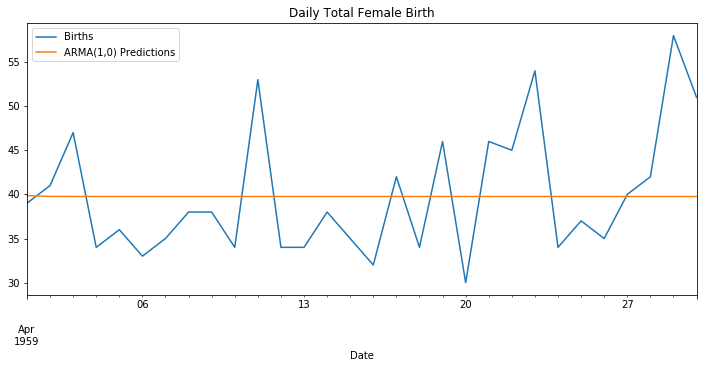

In [20]:
test.plot()
predictions.plot()
plt.title('Daily Total Female Birth')
plt.legend();

In [21]:
print('Actual mean value of test data was {} while predicted mean is {}'.format(test.mean().values[0], predictions.mean()))

Actual mean value of test data was 39.833333333333336 while predicted mean is 39.76685707795533


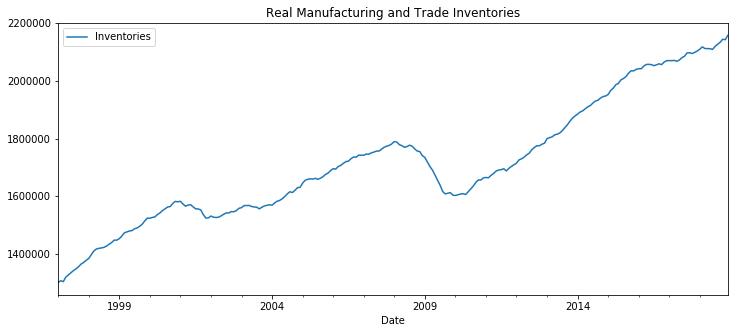

In [28]:
df2.plot()
plt.title('Real Manufacturing and Trade Inventories');

In [23]:
df2.head()

,Inventories
Date,
1997-01-01,1301161
1997-02-01,1307080
1997-03-01,1303978
1997-04-01,1319740
1997-05-01,1327294


In [24]:
from statsmodels.tsa.seasonal import seasonal_decompose

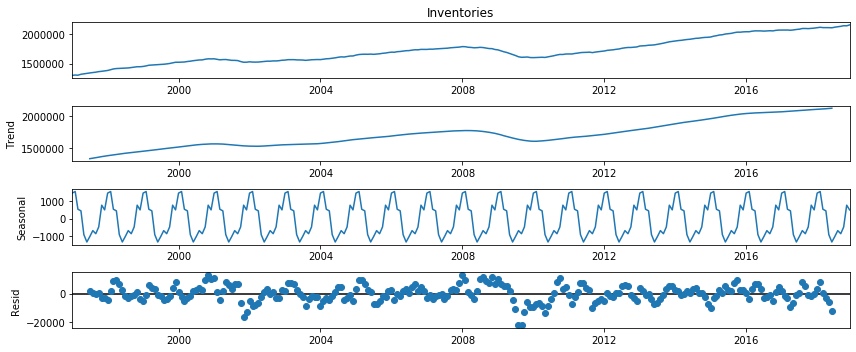

In [27]:
seasonal_decompose(df2['Inventories']).plot();

In [29]:
auto_arima(df2['Inventories'], start_p=0, max_p=6, start_q=0, max_q=6, seasonal=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  263
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2610.253
Method:                       css-mle   S.D. of innovations           4938.258
Date:                Fri, 03 Jul 2020   AIC                           5228.505
Time:                        22:18:02   BIC                           5242.794
Sample:                             1   HQIC                          5234.248
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3499.0725   1315.252      2.660      0.008     921.225    6076.920
ar.L1.D.y      0.9038      0.039     23.413      0.000       0.828       0.979
ma.L1.D.y     -0.5733      0.076     -7.547      0.000      -0.722      -0.424
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1065           +0.0000j            1.1065            0.0000
MA.1            1.7444           +0.0000j            1.7444            0.0000
-----------------------------------------------------------------------------
"""

In [30]:
adf_test(df2['Inventories'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -0.087684
p-value                   0.950652
# lags used               5.000000
# observations          258.000000
critical value (1%)      -3.455953
critical value (5%)      -2.872809
critical value (10%)     -2.572775
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [31]:
from statsmodels.tsa.statespace.tools import diff

In [32]:
df2['diff_1'] = diff(df2['Inventories'], k_diff=1)

In [33]:
df2.head()

,Inventories,diff_1
Date,,
1997-01-01,1301161,NaN
1997-02-01,1307080,5919.0
1997-03-01,1303978,-3102.0
1997-04-01,1319740,15762.0
1997-05-01,1327294,7554.0


In [34]:
adf_test(df2['diff_1'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -3.412249
p-value                   0.010548
# lags used               4.000000
# observations          258.000000
critical value (1%)      -3.455953
critical value (5%)      -2.872809
critical value (10%)     -2.572775
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


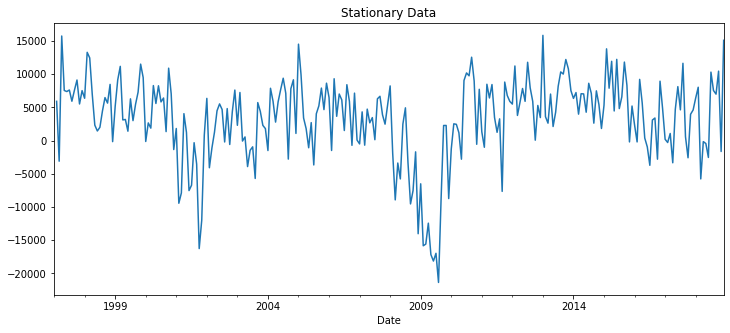

In [36]:
df2['diff_1'].plot()
plt.title('Stationary Data');
# data is stationary after diff= 1 as suggested by auto arima

In [39]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

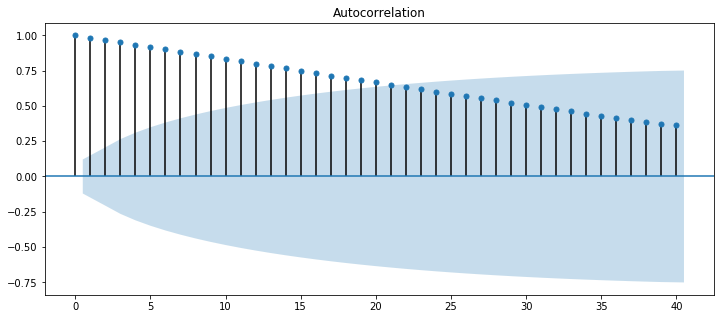

In [41]:
plot_acf(df2['Inventories'], lags=40);

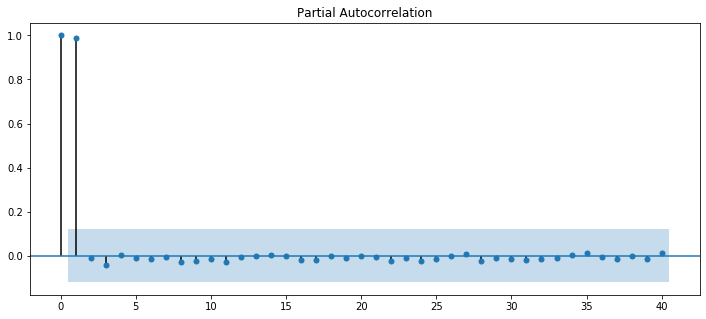

In [42]:
plot_pacf(df2['Inventories'], lags=40);
# AR = 1 b/c sharp dropoff after 1 peak

# Train test split

In [51]:
train = df2.iloc[:252]['Inventories']

In [52]:
test = df2.iloc[252:]['Inventories']

In [53]:
model = ARIMA(train, order=(1,1,1))

In [54]:
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:          D.Inventories   No. Observations:                  251
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2486.395
Method:                       css-mle   S.D. of innovations           4845.028
Date:                Fri, 03 Jul 2020   AIC                           4980.790
Time:                        22:26:26   BIC                           4994.892
Sample:                    02-01-1997   HQIC                          4986.465
                         - 12-01-2017                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                3197.5698   1344.866      2.378      0.017     561.681    5833.459
ar.L1.D.Inventories     0.9026      0.039     23.010      0.000       0.826       0.979
ma.L1.D.Inventories    -0.5581      0.079     -7.048      0.000      -0.713      -0.403
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1080           +0.0000j            1.1080            0.0000
MA.1            1.7918           +0.0000j            1.7918            0.0000
-----------------------------------------------------------------------------
"""

In [56]:
model_predict = result.predict(start = len(train), end=len(train) + len(test)-1, typ='levels', dynamic=False).rename('ARIMA(1,1,1) Predictions')

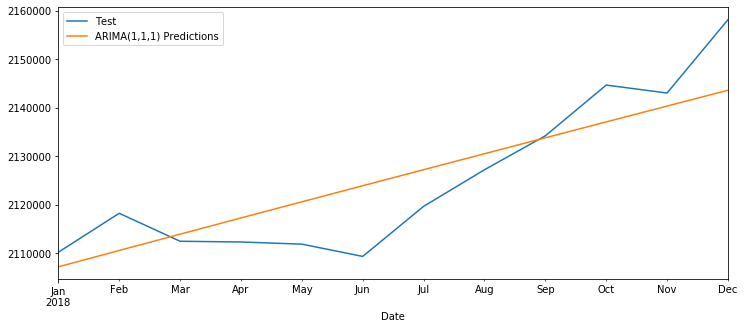

In [57]:
test.plot(label='Test')
model_predict.plot()
plt.legend();


In [58]:
from statsmodels.tools.eval_measures import rmse

In [59]:
rmse(test, model_predict)

7789.597562766068

In [61]:
print('Actual mean value of test data was {} while predicted mean is {}'.format(test.mean(), model_predict.mean()))

Actual mean value of test data was 2125075.6666666665 while predicted mean is 2125465.2713944274


# Retrain the model on the full data, and forecast the future

In [62]:
model = ARIMA(df2['Inventories'], order=(1,1,1)).fit()


In [63]:
forecast = model.predict(start=len(df2), end= len(df2)+11, typ='levels', dynamic=False).rename('ARIMA(1,1,1) Forecast')

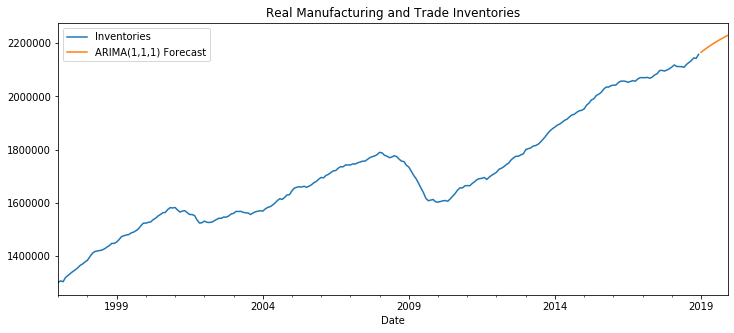

In [66]:
df2['Inventories'].plot()
forecast.plot()
plt.title('Real Manufacturing and Trade Inventories')
plt.legend();